# MBC 2021 - Machine Learning for Wi-Fi - from the hype to the first real example

by Flavio Correa - @correaflavio

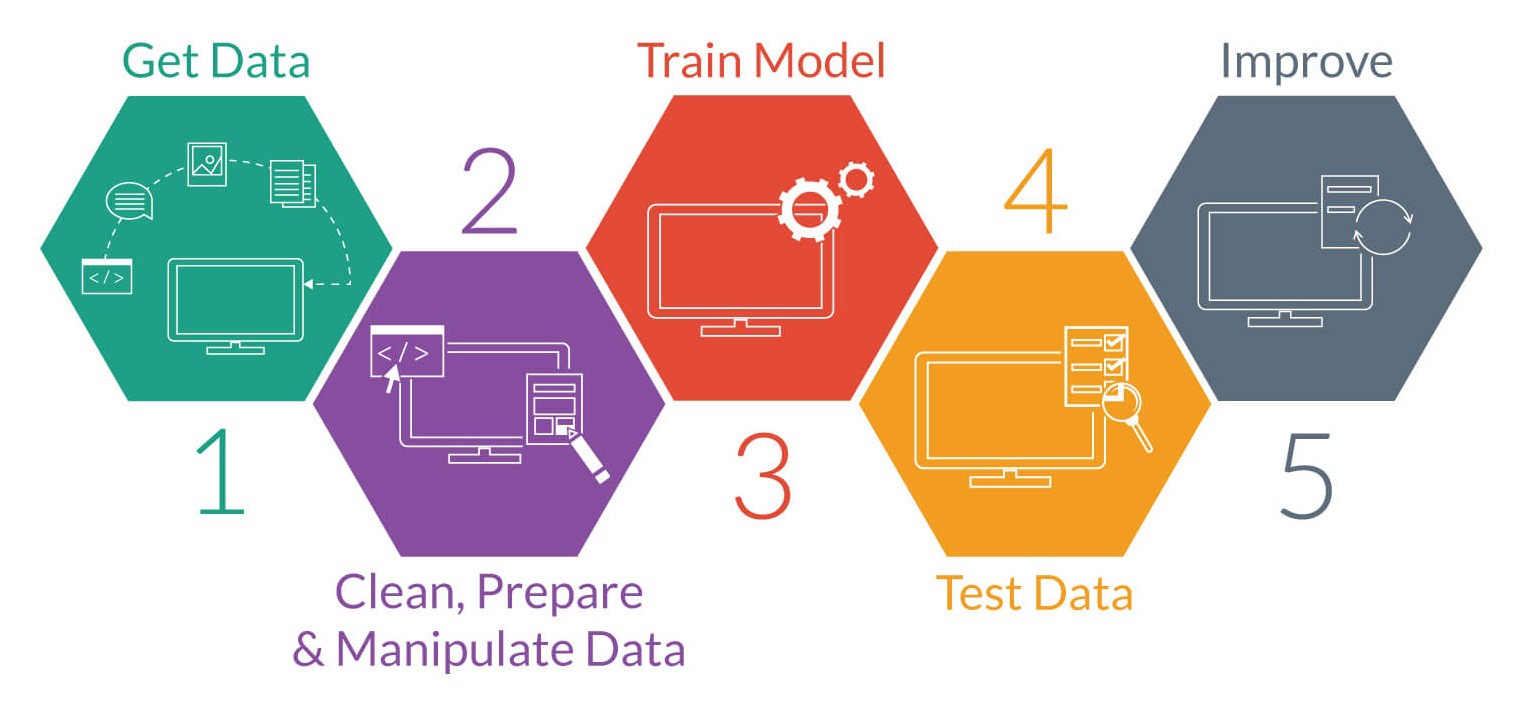

Image Source: https://towardsdatascience.com/wtf-is-machine-learning-a-quick-guide-39457e49c65b

###**First you need is data. Sources of data for Wi-Fi related scenarios**
- **Wireless LAN Controller Telemetry** - APs, clients, mobility, rrm, rogue, etc.
- **Location Services data** - number of visitors, devices, time of visit, number of visits, raw x/y data, etc. 
- **Wi-Fi and BLE IoT data** - temperature, pressure, humidity, CO2 level, PiR presence, etc.

###**Supervised Learning**

For each input in the training data set, there will be an known output associated.

- **Classification**: assign groups to input data based on previous data

- **Regression**: predicts real values based on previous data


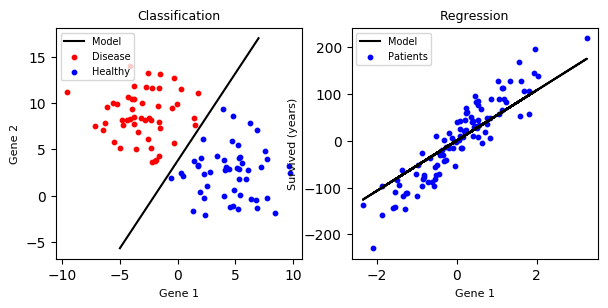

Image Source: https://dev.to/petercour/machine-learning-classification-vs-regression-1gn

###**Classification Example**

Let's run a first basic example that is about creating a Machine Learning model that can **automatically classify rogue access points**, based in previous examples observed. 
<br><br>
You can also think about automating a containment rule or a switch port shutdown as a final objetive for this classification problem.

## How to capture rogue data


First you need to **capture rogue data** from your network. These will be your examples to train the model. Wireless LAN controller streaming telemetry data or Cloud based management APIs can be used. Here you have the documentation for each case.

  - Catalyst 9800 Programmability and Telemetry Deployment Guide:
https://www.cisco.com/c/en/us/td/docs/wireless/controller/technotes/8-8/b_c9800_programmability_telemetry_dg.html

  - IOS-XE Model Driven Telemetry - DevNet Learning Lab:
    https://developer.cisco.com/learning/modules/iosxe_telemetry

  - IOS-XE 17.6.1 Yang Models: **Cisco-IOS-XE-wireless-rogue-cfg.yang, Cisco-IOS-XE-wireless-rogue-oper.yang, Cisco-IOS-XE-wireless-rogue-types.yang**:
https://github.com/YangModels/yang/tree/master/vendor/cisco/xe/1761

  - Meraki Air Marshal: https://documentation.meraki.com/MR/Monitoring_and_Reporting/Air_Marshal

  - MBC 2019 - Network Automation and Telemetry for Wi-Fi:
https://youtu.be/antXBApxcB4

##Creating Features and Labels

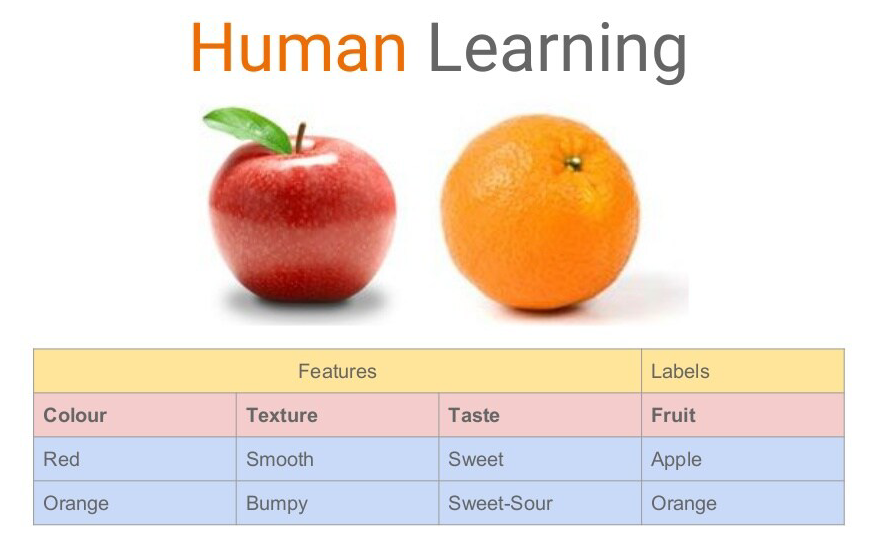

Image source: https://www.slideshare.net/lakshya90/machine-learning-workshop-84176551

You will also need to think about what will be the **characteristics** that you will use to evaluate the rogue status. These are called **features**.

Below we have an example of data captured via Meraki Air Marshal API regarding a rogue detected. 

Full documentation and API endpoint tests: https://documenter.getpostman.com/view/7928889/SVmsVg6K#0440f206-a7ec-4060-9073-4768c7e4f729

###Getting data from API: Meraki Air Marshal Rogue event example.

This is a REST API response from Meraki Rogue API endpoing (/network/id/airmarshal) in JSON format.

In [ ]:
api_response = []

api_response = [
  {
    "ssid": "linksys",
    "bssids": [
      {
        "bssid": "00:11:22:33:44:55",
        "contained": False,
        "detectedBy": [
          {
            "device": "Q234-ABCD-5678",
            "rssi": 17
          }
        ]
      }
    ],
    "channels": [
      36,
      40
    ],
    "firstSeen": 1518365681,
    "lastSeen": 1526087474,
    "wiredMacs": [
      "00:11:22:33:44:55"
    ],
    "wiredVlans": [
      0,
      108
    ],
    "wiredLastSeen": 1526087474
  }
]

We will convert it to a python dictionary first and parse just the atributes that we want, to build a pandas dataframe that will be used in our ML model later.

It's a list of dictionaries, getting the first example of the list

In [ ]:
api_response[0]

{'bssids': [{'bssid': '00:11:22:33:44:55',
   'contained': False,
   'detectedBy': [{'device': 'Q234-ABCD-5678', 'rssi': 17}]}],
 'channels': [36, 40],
 'firstSeen': 1518365681,
 'lastSeen': 1526087474,
 'ssid': 'linksys',
 'wiredLastSeen': 1526087474,
 'wiredMacs': ['00:11:22:33:44:55'],
 'wiredVlans': [0, 108]}

###Parsing the data from JSON to a Dataframe & Selecting the features

Extract the data from nested dictionaries into a flat columns based structure with json_normalize module.

Assign it to a pandas dataframe that will be used to easily manipulate the data later.

Each column is a feature that we can potentially use to classify a rogue. We can also add more data from different sources like location, compare the SSID strings with RegEx, create categorical features like RogueOnWire, etc. 

**This is where the SME (you) can make a difference.**

In [ ]:
#Example for 1 sample event. You will need to run it for each example when you have your data.

import pandas as pd
import json

#flatten the json
df1 = pd.json_normalize(api_response[0])

#flatten the bssid key / value
df2 = pd.json_normalize(df1['bssids'][0][0])

#flatten the detectedBy key / value
df3 = pd.json_normalize(df2['detectedBy'][0][0])

#remove the original columns that were flatten
df1.drop(columns=['bssids'], inplace=True)
df2.drop(columns=['detectedBy'], inplace=True)

#group all the 3 dataframes created in a single one
rogue_df = pd.concat([df1, df2, df3], axis=1)

#rename the column to have meaningful names
rogue_df.rename(columns={"device": "detectedBy_AP", "rssi": "detectedBy_rssi"}, inplace=True)

#create a new feature / column with the information about if the AP is connected to the wire.
if rogue_df['wiredMacs'][0] != "":
  rogue_df['rogueOnWire'] = 1
else: rogue_df['rogueOnWire'] = 0

In [ ]:
rogue_df

,ssid,channels,firstSeen,lastSeen,wiredMacs,wiredVlans,wiredLastSeen,bssid,contained,detectedBy_AP,detectedBy_rssi,rogueOnWire
0,linksys,"[36, 40]",1518365681,1526087474,[00:11:22:33:44:55],"[0, 108]",1526087474,00:11:22:33:44:55,False,Q234-ABCD-5678,17,1


###Labeling the data

We also need to **add labels to the data**, saying if this was an example of a malicious or friendly rogue.

Data labeling is a requirement and in this case can be done by a subject expert.

We could also try Unsupervised Learning as a way to group de data obtained as malicous or not, without having to label it. 

Here we are using the Supervised Learning scenario.

In [ ]:
rogue_df['status'] = "not_malicious"

In [ ]:
rogue_df

,ssid,channels,firstSeen,lastSeen,wiredMacs,wiredVlans,wiredLastSeen,bssid,contained,detectedBy_AP,detectedBy_rssi,rogueOnWire,status
0,linksys,"[36, 40]",1518365681,1526087474,[00:11:22:33:44:55],"[0, 108]",1526087474,00:11:22:33:44:55,False,Q234-ABCD-5678,17,1,not_malicious


###Selecting features and creating the final dataset

Since it's our first example, let's use just few features - ssid, detectedBy_rssi and rogueOnWire - and remove the others.

In [ ]:
df = rogue_df.drop(columns=['channels','firstSeen', 'lastSeen', 'wiredMacs', 'wiredVlans', 'wiredLastSeen', 'bssid', 'contained', 'detectedBy_AP'])
df

,ssid,detectedBy_rssi,rogueOnWire,status
0,linksys,17,1,not_malicious


But we are not done yet! To run our models we need to have our feature categorical values converted to numbers and the same for our labels.

In this case we will do the following:

- **SSID**: calculate the similarity with the SSIDs of your network. 0 (zero) means it's the same name and the higher the number more different it is. In this case the higher the value the better, meaning it's not similar to our SSID.

- **rogueOnWire**: since we've created this feature (feature engineering), we already made it a numerical value.

- **rssi**: we don't need to change the rssi values in this case, it's already a number (module of the rssi original value)

- **Labels**: malicious = 1 and not malicious = 0



Calculating the SSID similarity:    

We have the SSIDs of our network in a python list and we will compare the rogue SSID with each element of the list, compute the similarity and use the higher number (worst case).

In [ ]:
#List of valid SSIDs in your network. Can be manually created or collected via API or Telemetry as well.
network_ssids_list = ['mbc_guest', 'mbc_admin', 'linksys_home','linksys']

The Levenshtein distance calculates how many characters must be changed in the word to get to transform it into the same word.

If the word is the same, the distance value is zero. The larger the value, more different the word.

There are different ways to compute that. This is just an example.

In [ ]:
!pip install Levenshtein

     |████████████████████████████████| 110 kB 5.1 MB/s 
     |████████████████████████████████| 1.6 MB 48.9 MB/s 


In [ ]:
#The lower the value, the close the ssid name or more similar.
#ssid_similarity = 0 means the same ssid name

from Levenshtein import distance

rogue_ssid = df['ssid'][0]
print('Rogue SSID example:', rogue_ssid)
print()

similarity_id = 1000

for network_ssid in network_ssids_list:
  ssid_similarity = distance(rogue_ssid, network_ssid)
  print('SSID similarity with', network_ssid, ':', ssid_similarity)
  if ssid_similarity < similarity_id:
    similarity_id = ssid_similarity
print()
print('SSID similarity that will be computed:', similarity_id)

Rogue SSID example: linksys

SSID similarity with mbc_guest : 8
SSID similarity with mbc_admin : 9
SSID similarity with linksys_home : 5
SSID similarity with linksys : 0

SSID similarity that will be computed: 0


In [ ]:
df['ssid'][0] = similarity_id

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
status = df['status'][0]
if status == "malicious":
  df['status'] = 1
else: df['status'] = 0 

In [ ]:
df

,ssid,detectedBy_rssi,rogueOnWire,status
0,0,17,1,0


##Loading the full dataset generated and get to know the data

In [ ]:
!wget https://github.com/correaflavio/mbc2021/raw/main/rogue_new.xls

--2021-11-17 12:26:12--  https://github.com/correaflavio/mbc2021/raw/main/rogue_new.xls
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/correaflavio/mbc2021/main/rogue_new.xls [following]
--2021-11-17 12:26:12--  https://raw.githubusercontent.com/correaflavio/mbc2021/main/rogue_new.xls
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27136 (26K) [application/octet-stream]
Saving to: ‘rogue_new.xls’

rogue_new.xls       100%[===================>]  26.50K  --.-KB/s    in 0.001s  

2021-11-17 12:26:12 (39.0 MB/s) - ‘rogue_new.xls’ saved [27136/27136]



In [ ]:
import pandas as pd
dataset = pd.read_excel('rogue_new.xls')

In [ ]:
dataset.head()

,ssid,detectedBy_rssi,rogueOnWire,status
0,8,17,0,0
1,1,85,1,1
2,2,55,0,1
3,1,32,0,0
4,0,94,1,1


In [ ]:
dataset.shape

(51, 4)

In [ ]:
print('Number of examples available in the dataset:', dataset.shape[0])
print('Number of features available in the dataset:', dataset.shape[1]-1)

Number of examples available in the dataset: 51
Number of features available in the dataset: 3


###Features distribution & data exploration

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa5389ffa90>,
      dtype=object)

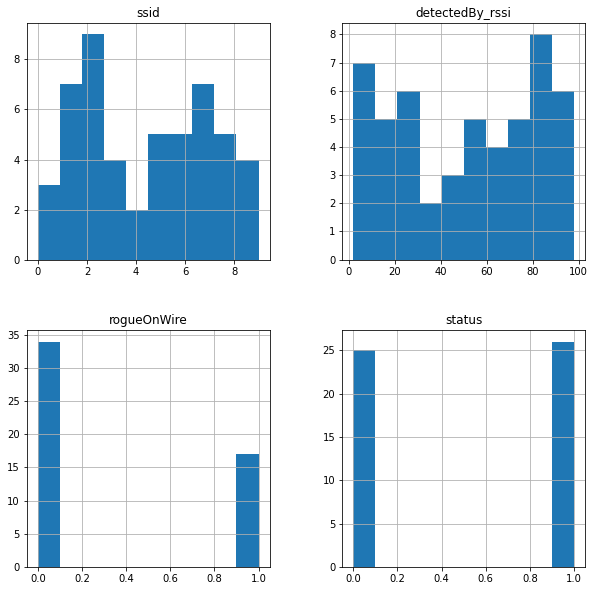

In [ ]:
dataset.hist(figsize=(10,10))

###Let's visualize the features in 2D and 3D

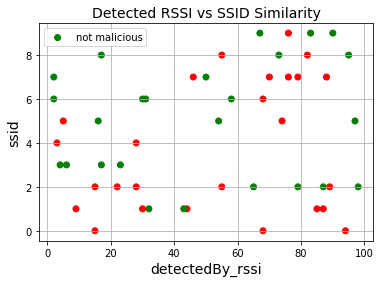

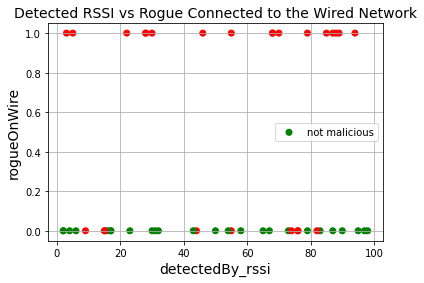

In [ ]:
#2D visualization
import matplotlib.pyplot as plt
import pylab as pl
import numpy as np

# Function to map the colors as a list from the input list of x variables
def pltcolor(lst):
    cols=[]
    for l in lst:
        if l==1:
            cols.append('red')
        else: cols.append('green')
    return cols

# Create the colors list using the function above
colors=pltcolor(dataset['status'])

plt.scatter(dataset['detectedBy_rssi'],dataset['ssid'], color=colors, label="not malicious")
plt.title('Detected RSSI vs SSID Similarity', fontsize=14)
plt.xlabel('detectedBy_rssi', fontsize=14)
plt.ylabel('ssid', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

plt.scatter(dataset['detectedBy_rssi'],dataset['rogueOnWire'], color=colors, label="not malicious")
plt.title('Detected RSSI vs Rogue Connected to the Wired Network', fontsize=14)
plt.xlabel('detectedBy_rssi', fontsize=14)
plt.ylabel('rogueOnWire', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

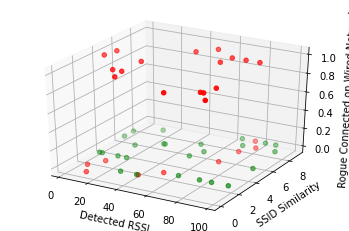

In [ ]:
#3D visualization

from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = dataset['detectedBy_rssi'].values

ys = dataset['ssid'].values

zs = dataset['rogueOnWire'].values

ax = plt.axes(projection='3d')
ax.set_xlabel('Detected RSSI')
ax.set_ylabel('SSID Similarity')
ax.set_zlabel('Rogue Connected on Wired Network')
ax.scatter3D(xs, ys, zs, c=colors);

In [ ]:
#let's call X the array of features and y the arrays for labels

X = dataset[["ssid","detectedBy_rssi", "rogueOnWire"]]
X.head()

,ssid,detectedBy_rssi,rogueOnWire
0,8,17,0
1,1,85,1
2,2,55,0
3,1,32,0
4,0,94,1


In [ ]:
y = dataset[['status']]
y.head()

,status
0,0
1,1
2,1
3,0
4,1


##Splitting the dataset in training and test

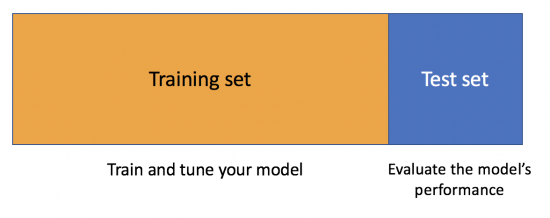

Source: https://docs.splunk.com/Documentation/ITSI/4.10.2/SI/TrainModel

In [ ]:
from sklearn.model_selection import train_test_split

p = 0.3 # percentage of elements used in the test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = p)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((35, 3), (16, 3), (35, 1), (16, 1))

In [ ]:
X_train.head()

,ssid,detectedBy_rssi,rogueOnWire
13,7,79,1
38,8,82,0
27,3,6,0
33,1,43,0
41,2,87,0


In [ ]:
X_test.head()

,ssid,detectedBy_rssi,rogueOnWire
19,8,55,1
20,7,76,0
4,0,94,1
48,6,58,0
18,3,17,0


##Training a Decision Tree Model

In [ ]:
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.metrics import accuracy_score

###Training the model

In [ ]:
# Decision Tree model
model = DecisionTreeClassifier(
    criterion="gini", # used to measure the split quality
     max_depth=4, # used to define the maximum depth of the tree
    random_state=42 # seed to have always the same results
 )

# Building the model using the method fit
# Use the training dataset to build the model
model.fit(
    X_train, # train examples with the features
    y_train # train examples with the class or target value
)


DecisionTreeClassifier(max_depth=4, random_state=42)

###Calculating the model "quality" using the accuracy metric and the confusion matrix

In [ ]:
# prediction based in the model trained
# generate the y_pred using the model and the test data
y_pred = model.predict(X_test)

#compare the predicted data with the test data to get how accurate the model is
acc = round(accuracy_score(y_test, y_pred), 4)
print(f"Accuracy: {acc}")

Accuracy: 0.875


In [ ]:
model_dt = model
y_test_dt = y_test
y_pred_dt = y_pred

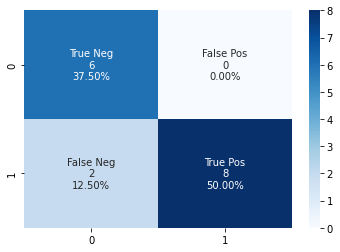

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, y_pred_dt)


group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

###Estimating the contribution of each feature in the model

In [ ]:
feature_names = ['ssid', 'detectedBy_rssi', 'rogueOnWire']

In [ ]:
class_names = ['not_malicious', 'malicious']

In [ ]:
sorted(zip(model_dt.feature_importances_, feature_names),reverse=True)

[(0.536802973977695, 'rogueOnWire'),
 (0.3867203634861628, 'detectedBy_rssi'),
 (0.07647666253614216, 'ssid')]

##Visualizing the Decision Tree

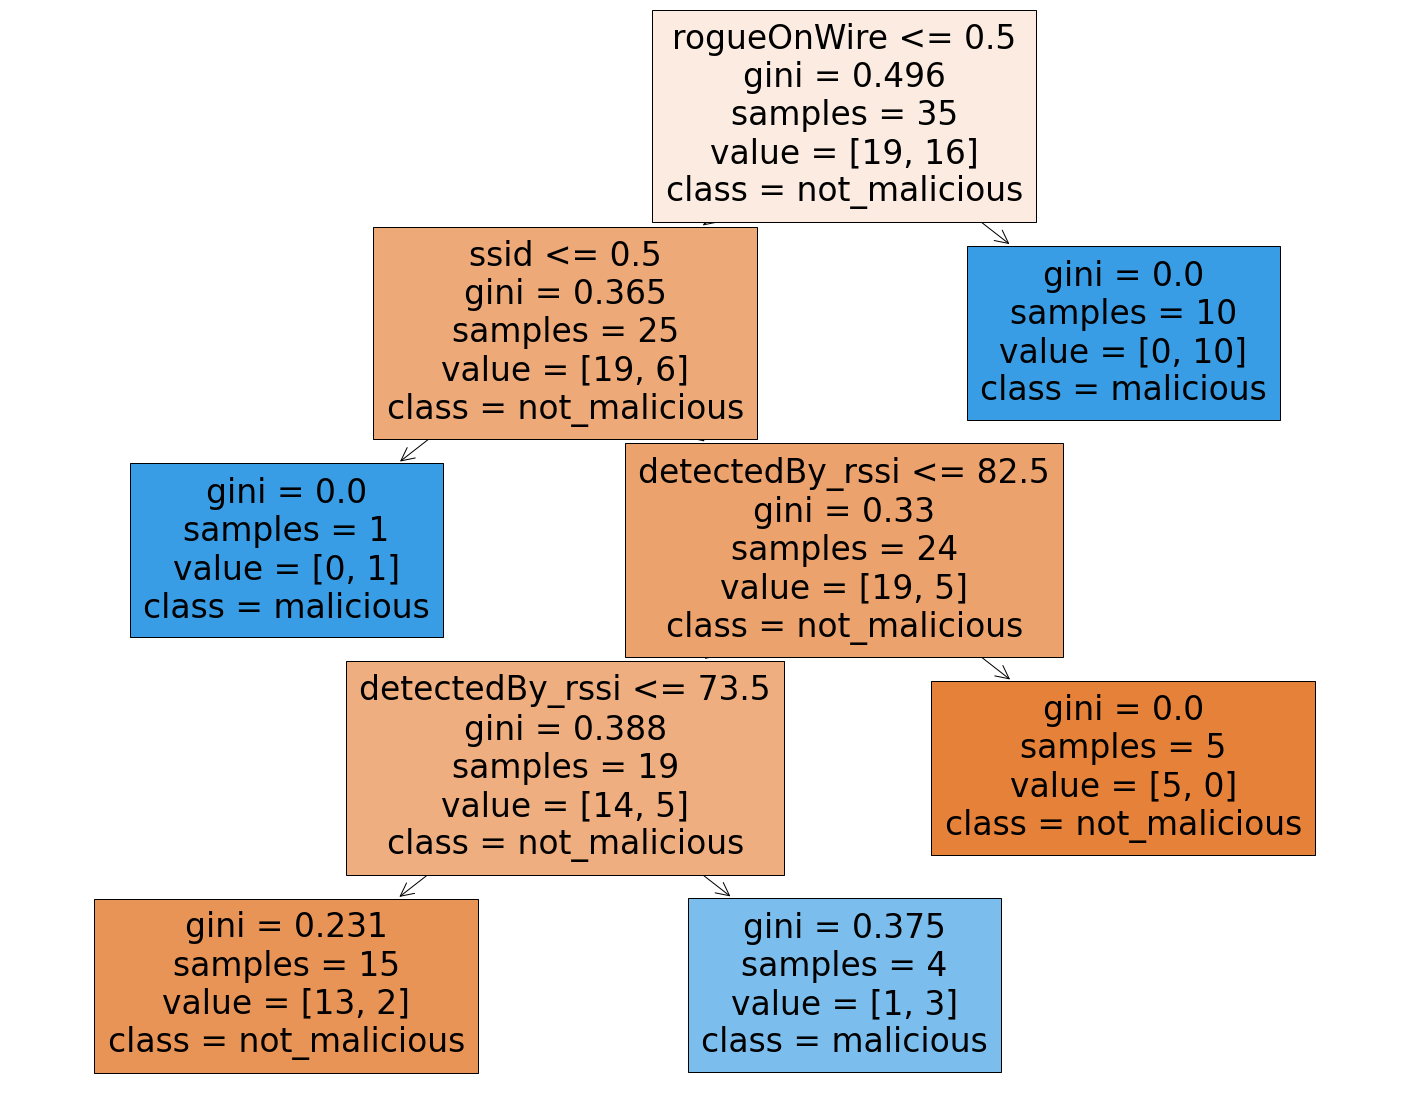

In [ ]:
from sklearn import tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model_dt, 
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

##Predicting a new event

Now we can use the model built using decision trees to predict if a new rogue detected is malicious or not.

In this case we will use in our example a rogue with the following characteristics:

- SSID is very similar with similarity score of 2
- Rogue was detected with very high RSSI of -17dBm
- It was also detected on the wired network

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:

#Array with the features of this new event detected
new_event_features = [[2, 17, 1]]

In [ ]:
#Necessary transformation to use it as an input to our model
new_event = np.array(new_event_features)
new_event.reshape(1, -1)
new_event.shape 

(1, 3)

In [ ]:
#Let's use the model that we have trained
model_dt

DecisionTreeClassifier(max_depth=4, random_state=42)

In [ ]:
#We will use the method .predict to predict the class for this new example
new_event_pred = model_dt.predict(new_event)

In [ ]:
#Print the predicted value:
if list(new_event_pred)[0] == 0:
  print('This Rogue is not malicious')
else: print('The careful, this Rogue is malicious')

The careful, this Rogue is malicious


### You can always try different ML algorithms or capture more data to improve your results

In [ ]:
#Using scikit learn you can easily try different ML algorithms like random forest, LR, SVMs, etc.

##You can try now with your own data, using the model trained

In [ ]:
print('<<<<<<<<Start>>>>>>>>>')
ssid_name = input("Enter your network oficial SSID:")
rogue_ssid = input("Enter the SSID of the Rogue AP detected:")
rogue_rssi = input("Enter the RSSI of the Rogue AP detected:")
rogue_onwire = input("Is the rogue connected to your network (yes/no):")
print()
print('Thanks for the inputs! We are processing your request!')

#print(ssid_name,rogue_ssid,rogue_rssi,rogue_onwire)

<<<<<<<<Start>>>>>>>>>
Enter your network oficial SSID:flavio
Enter the SSID of the Rogue AP detected:flavio123
Enter the RSSI of the Rogue AP detected:-55
Is the rogue connected to your network (yes/no):yes

Thanks for the inputs! We are processing your request!


In [ ]:
from Levenshtein import distance

ssid_similarity = distance(rogue_ssid, ssid_name)
print('SSID similarity with SSID', ssid_name, ':', ssid_similarity)

if rogue_onwire == 'yes':
  rogueOnWire = 1
elif rogue_onwire == 'no':
  rogueOnWire = 0
else: print('Invalid Rogue On Wire value, it just be yes or no')

SSID similarity with SSID flavio : 3


In [ ]:
new_event_features = [[ssid_similarity, abs(float(rogue_rssi)), rogueOnWire]]
new_event = np.array(new_event_features)
new_event.reshape(1, -1)
new_event_pred = model_dt.predict(new_event)
if list(new_event_pred)[0] == 0:
  print('The Rogue is not malicious')
else: print('Be careful, this Rogue is malicious')

Be careful, this Rogue is malicious




---



---



##This is just the beginning!! Today we have limited time but here you have more ideas to explore!

There are many more possible examples about how you can start using ML in your Wi-Fi projects and operations.

Here are some other examples that we won't have time to go over today together!

###**Regression Example**

Using regression instead of classification, we can calculate a value based in the features of the examples collected.

Also in this case, instead of looking the number of False Positives and False Negatives, we compute the loss function of the data points versus the value predicted by model.



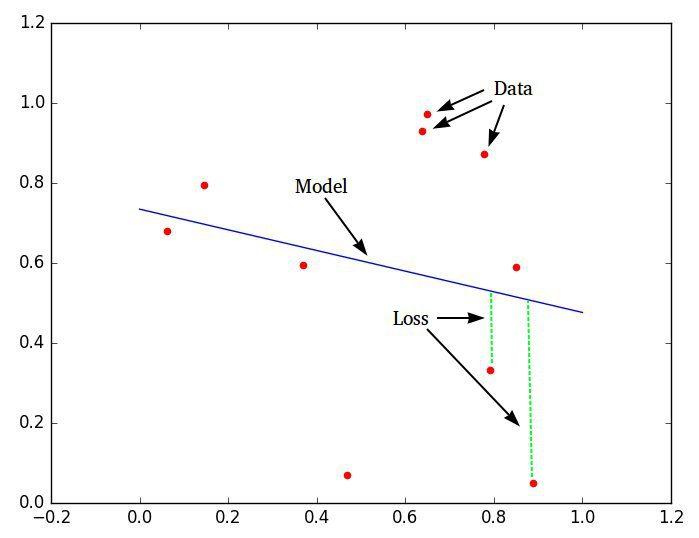

Image Source:https://www.kdnuggets.com/2017/06/regression-analysis-really-machine-learning.html 

This could be used in a lot of different scenarios like:

- We can use **Wi-Fi and/or BLE RSSI measurements to build our on location algorithm based in the fingerprints** collected.

- Predict the **Throughput of a client based in observations made in the network looking RSSI, SNR, Tput of the client, together with AP data like number of clients, channel width, channel utilization** and many others.


###**Time Series Forecasting**

When you have data that the sequence of it matters in the problem that you are trying to solve, you need to use a special approach that considers your data a time series type.


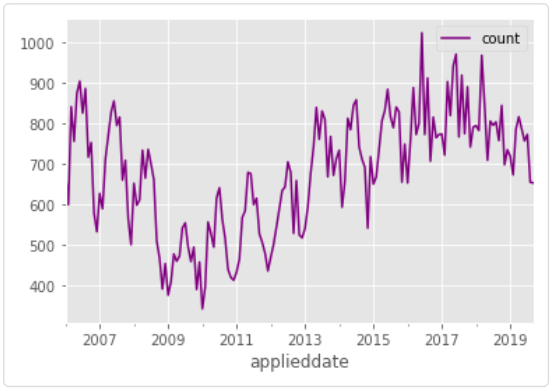

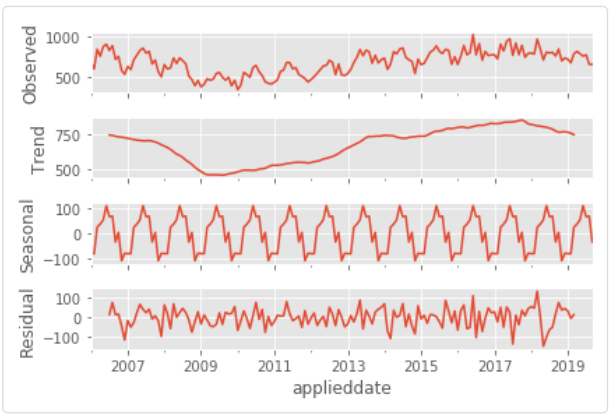

Image Source: https://dev.socrata.com/blog/2019/10/07/time-series-analysis-with-jupyter-notebooks-and-socrata.html


We have a lot of different use cases for time series analysis, and this also applies to Wi-Fi related scenarios.

Here are some examples:


- Try to **predict the number of employees that will be in the office** based in the measurements that we are getting in the last days and weeks. The sazonality of the data is key to predict it since people may avoid to go to the office on Mondays and Fridays.

- Use channel plan information colleted during the days and weeks, to **suggest a channel change or a different channel plan** based in previous observations. Channels can change depending of interferers that may show up during the day.


##I hope you enjoyed and will have fun combining Wi-Fi and ML!